### Resources

* [Challenge Instructions](https://github.com/RecList/evalRS-CIKM-2022#how-to-join-the-race)
* [Data Exploration Notebook](https://www.kaggle.com/code/peppeatta/exploratory-data-analysis-on-the-evalrs-dataset/notebook)
* [Reclist Website](https://reclist.io)

## At the end of this notebook

* You should be able to understand how the dataset is structured
* You shuld be able to write your own models to solve the challenge

In [ ]:
%%capture
!git clone https://github.com/RecList/evalRS-CIKM-2022
!cd evalRS-CIKM-2022 ; git pull
!cd evalRS-CIKM-2022; pip install -r requirements.txt

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.manifold import TSNE
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import matplotlib.cm as cm

np.random.seed(12)

In [ ]:
sys.path

['/home/msivanes/Documents/1Projects/evalRS-CIKM-2022',
 '/home/msivanes/miniconda3/envs/evalRS/lib/python38.zip',
 '/home/msivanes/miniconda3/envs/evalRS/lib/python3.8',
 '/home/msivanes/miniconda3/envs/evalRS/lib/python3.8/lib-dynload',
 '',
 '/home/msivanes/Documents/1Projects/evalRS-CIKM-2022/venv/lib/python3.8/site-packages']

In [ ]:
sys.path.insert(0, 'evalRS-CIKM-2022/')

In [ ]:
from evaluation.EvalRSRunner import EvalRSRunner
from evaluation.EvalRSRunner import ChallengeDataset
from evaluation.EvalRSRecList import EvalRSRecList
from reclist.abstractions import RecModel

## Data - LastFM Songs

This Data Challenge is based on the [LFM-1b Dataset, Corpus of Music Listening Events for Music Recommendation.](http://www.cp.jku.at/datasets/LFM-1b/) The use case is a typical user-item recommendation scenario: at prediction time, we have a set of target users to which we need to recommend a set of songs to listen to. To achieve that, we have historical anonymous data on previous music consumptions from users in the same setting.



### Exploratory Data Analysis

We are not goint to do much exploratory data analysis here. I will mainly go over what's in the dataset and how can we extract interesting information.
BUT: we got you covered! [here's a notebook for you](https://www.kaggle.com/code/peppeatta/exploratory-data-analysis-on-the-evalrs-dataset/notebook).

### Let's start with the data

We have a simple wrapper class that downloads the data for you. This is going to take a bit as it is preparing quite a few things in the background.

In [ ]:
from nbdev.showdoc import show_doc

In [ ]:
show_doc(ChallengeDataset)

---

### ChallengeDataset

>      ChallengeDataset (num_folds=4, seed:int=None, force_download:bool=False)

Initialize self.  See help(type(self)) for accurate signature.

In [ ]:
dataset = ChallengeDataset(num_folds=4, seed=12, force_download=False)

LFM dataset already downloaded. Skipping download.
Loading dataset.
Generating folds.
Generating dataset hashes.


Let's look at the dataset a bit :) We have lots of information (but we will only use some in this tutorial)!

In [ ]:
dataset.path_to_dataset, dataset.df*?

dataset.df_events
dataset.df_tracks
dataset.df_users

In [ ]:
# these are our users
dataset.df_users.head()

,country,age,gender,playcount,registered_unixtime,country_id,gender_id,novelty_artist_avg_month,novelty_artist_avg_6months,novelty_artist_avg_year,...,relative_le_per_hour14,relative_le_per_hour15,relative_le_per_hour16,relative_le_per_hour17,relative_le_per_hour18,relative_le_per_hour19,relative_le_per_hour20,relative_le_per_hour21,relative_le_per_hour22,relative_le_per_hour23
user_id,,,,,,,,,,,,,,,,,,,,,
384,UK,35,m,42139,1035849600,0,0,0.276629,0.044439,0.309429,...,0.0279,0.0410,0.0811,0.1506,0.0377,0.0298,0.0132,0.0007,0.0001,0.0151
1206,NaN,-1,n,33103,1035849600,-1,1,0.437224,0.109671,0.513787,...,0.0016,0.0115,0.0276,0.0662,0.0790,0.0838,0.0995,0.1195,0.0968,0.0839
2622,NaN,-1,NaN,2030,1037404800,-1,-1,0.604828,0.043923,0.698983,...,0.1320,0.0493,0.0317,0.0470,0.0658,0.1127,0.1112,0.0680,0.0437,0.0254
2732,NaN,-1,n,147,1037577600,-1,1,0.756973,0.020071,0.882801,...,0.0598,0.0726,0.0171,0.0342,0.0769,0.1453,0.0470,0.0513,0.0085,0.0128
3653,UK,31,m,18504,1041033600,0,0,0.380005,0.045207,0.424411,...,0.0541,0.0518,0.0564,0.0554,0.0849,0.0954,0.0833,0.0657,0.0471,0.0595


In [ ]:
dataset.df_users.columns

Index(['country', 'age', 'gender', 'playcount', 'registered_unixtime',
       'country_id', 'gender_id', 'novelty_artist_avg_month',
       'novelty_artist_avg_6months', 'novelty_artist_avg_year',
       'mainstreaminess_avg_month', 'mainstreaminess_avg_6months',
       'mainstreaminess_avg_year', 'mainstreaminess_global',
       'cnt_listeningevents', 'cnt_distinct_tracks', 'cnt_distinct_artists',
       'cnt_listeningevents_per_week', 'relative_le_per_weekday1',
       'relative_le_per_weekday2', 'relative_le_per_weekday3',
       'relative_le_per_weekday4', 'relative_le_per_weekday5',
       'relative_le_per_weekday6', 'relative_le_per_weekday7',
       'relative_le_per_hour0', 'relative_le_per_hour1',
       'relative_le_per_hour2', 'relative_le_per_hour3',
       'relative_le_per_hour4', 'relative_le_per_hour5',
       'relative_le_per_hour6', 'relative_le_per_hour7',
       'relative_le_per_hour8', 'relative_le_per_hour9',
       'relative_le_per_hour10', 'relative_le_per_hour11'

In [ ]:
# these are the icolumnsctions users had with tracks on the platform
dataset.df_events.head()

,user_id,artist_id,album_id,track_id,timestamp,user_track_count
1047889016,50967444,3059,114114,336613,1409538054,1
1047889017,50967444,3059,114114,336156,1409537916,1
1047889018,50967444,3059,114114,339139,1409537712,1
1047889019,50967444,3059,114114,338514,1409537546,1
1047889059,50967444,677,3035,674449,1409532988,1


In [ ]:
# these are acutal tracks
dataset.df_tracks.head()

,track,artist_id,artist,albums_id,albums
track_id,,,,,
1,A Matter of Time,3,Foo Fighters,"[1, 67655, 605875, 682938, 889936, 2797722, 34...","['Wasting Light', 'Wasting Light (Deluxe Versi..."
2,Hangar 18,1,Megadeth,"[2, 693, 821, 2113, 12071, 13309, 17004, 83531...","['Rust In Peace', 'Countdown To Extinction', '..."
3,Up the Downstair,4,Porcupine Tree,"[84, 116, 13570, 283314, 302086, 303154, 35956...","['Up the Downstair', 'Coma Divine', 'Up The Do..."
5,Mixtaped,5,No-Man,"[5, 7654681]","['Schoolyard Ghosts', 'Schoolyard Ghosts Disc 1']"
6,Sounds that I Hear,6,Airbag,"[6, 340, 1139848]","['Sounds That I Hear', 'Identity', nan]"


In [ ]:
train0 = dataset._get_train_set(0);len(train0)

6867422

In [ ]:
train1 = dataset._get_train_set(1)

In [ ]:
len(train1)

6896224

In [ ]:
train2 = dataset._get_train_set(2);len(train2)

6890882

In [ ]:
dataset._test_set['fold'].max()

3

In [ ]:
# let's get a balanced sample from the data, it will be useful to develop our methods
# wait a tiny bit :)
train, test = dataset.get_sample_train_test()

In [ ]:
# here's how the train data looks
train_df = train

In [ ]:
test_df = test

In [ ]:
len(train_df), len(test_df)

(6896224, 29725)

In [ ]:
sample = train_df[:1000]

In [ ]:
len(dataset.df_events)

37926429

In [ ]:
train_df.head()

,user_id,artist_id,album_id,track_id,timestamp,user_track_count
43142,7438644,1312,2944,8507,1354982620,1
43143,7438644,1312,2944,8508,1354982427,1
43144,7438644,1312,2944,8509,1354982287,1
43145,7438644,1312,2944,8510,1354981997,1
43150,7438644,1313,2946,8515,1354981177,1


In [ ]:
len(sample)

1000

### Exploring

Let's write down some helper functions, shall we? This will also be useful later on

In [ ]:
def get_song_name(id_vocab):
    return dataset.df_tracks.loc[id_vocab, 'track']
  
def get_artist_from_song_id(internal_id):
    return dataset.df_tracks.loc[internal_id, 'artist']

def get_song_ids(song):
    return dataset.df_tracks[dataset.df_tracks["track"]==song]

I like Enter Shikari, let's look at some tracks from them!

In [ ]:
dataset.df_tracks[dataset.df_tracks["artist"] == "Enter Shikari"]

,track,artist_id,artist,albums_id,albums
track_id,,,,,
18581,Sorry You're Not a Winner,2868,Enter Shikari,"[6170, 155878, 235384, 280133, 286304, 286820,...","['Take To The Skies', ""Sorry You're Not a Winn..."
47814,"Sorry, You're Not a Winner",2868,Enter Shikari,"[6170, 154899, 235381, 280133, 333147, 496067,...","['Take To The Skies', ""Kerrang! The Album '08""..."
47831,Common Dreads,2868,Enter Shikari,[17854],['Common Dreads']
48500,Wall,2868,Enter Shikari,[17854],['Common Dreads']
48501,Juggernauts,2868,Enter Shikari,"[17854, 3776890, 4017389, 8547343, 9179535, 10...","['Common Dreads', 'Live in the Barrowland (Boo..."
...,...,...,...,...,...
3606171,Intro / Destabilise (Live from the Electric Ba...,2868,Enter Shikari,"[30364, 155485, 155854]","['A Flash Flood Of Colour', 'A Flash Flood Of ..."
4009598,Sorry You’re Not A Winner,2868,Enter Shikari,"[6170, 286820]","['Take To The Skies', 'Live From Planet Earth']"
4624762,Arguing With Thermometers - Goth-Trad Remix,2868,Enter Shikari,"[30364, 155854, 657535, 1473662, 5411486]","['A Flash Flood Of Colour', 'A Flash Flood of ..."


In [ ]:
get_artist_from_song_id(47814)

'Enter Shikari'

# Let's Solve the Challenge! 

We will now design a simple model to tackle the challenge. We will create track embeddings and use those to suggest a song to a user.

### CBOW Vector Space of Tracks

We will use CBOW on sequences of tracks from each user. CBOW is not the best method to do this, since it's window based (and we don't have a real context window I would say), still, it's interesting to see which patterns we can pick up just from the data we have.

We are going to treat the tracks listened by users as sequences of words. I'll just take the tracks and build sentences (trying to keep the tracks in order, for what is possible)!

Once we have these sequences we give them in input to word2vec (listening histories are going to be our sentences, and tracks are going to be our words) and we will build a vector space.

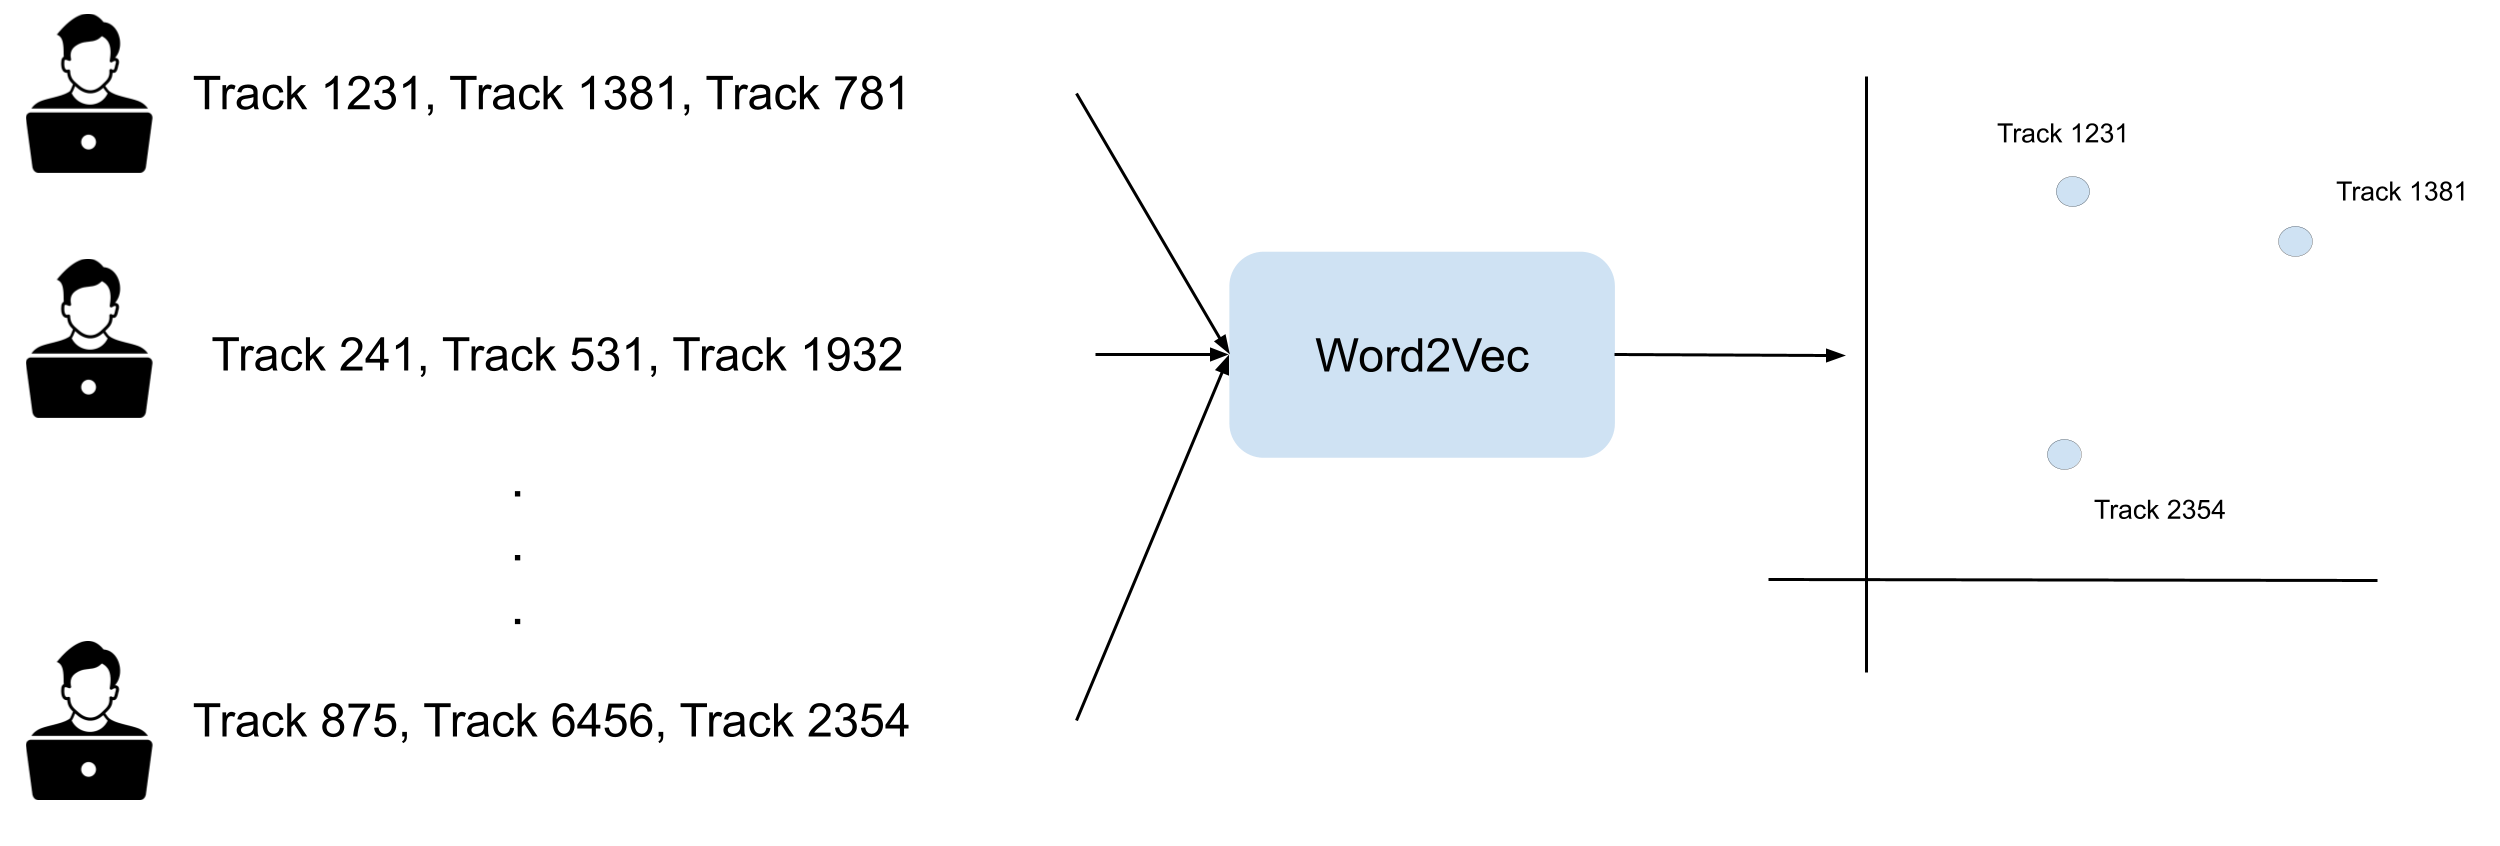

### CBOW RecSys

So now the question is...how do we use this to suggest novel tracks to a user? 

We approach the prolem in a very simple way: let's get the user's listening history, and average the embeddings of those tracks (or maybe a sample). Now, let's look at the most similar tracks to that vector in the embedding space. This is an easy approach but intuitively makes sense: it's probable that I will like things similar to the tracks I liked in the past.

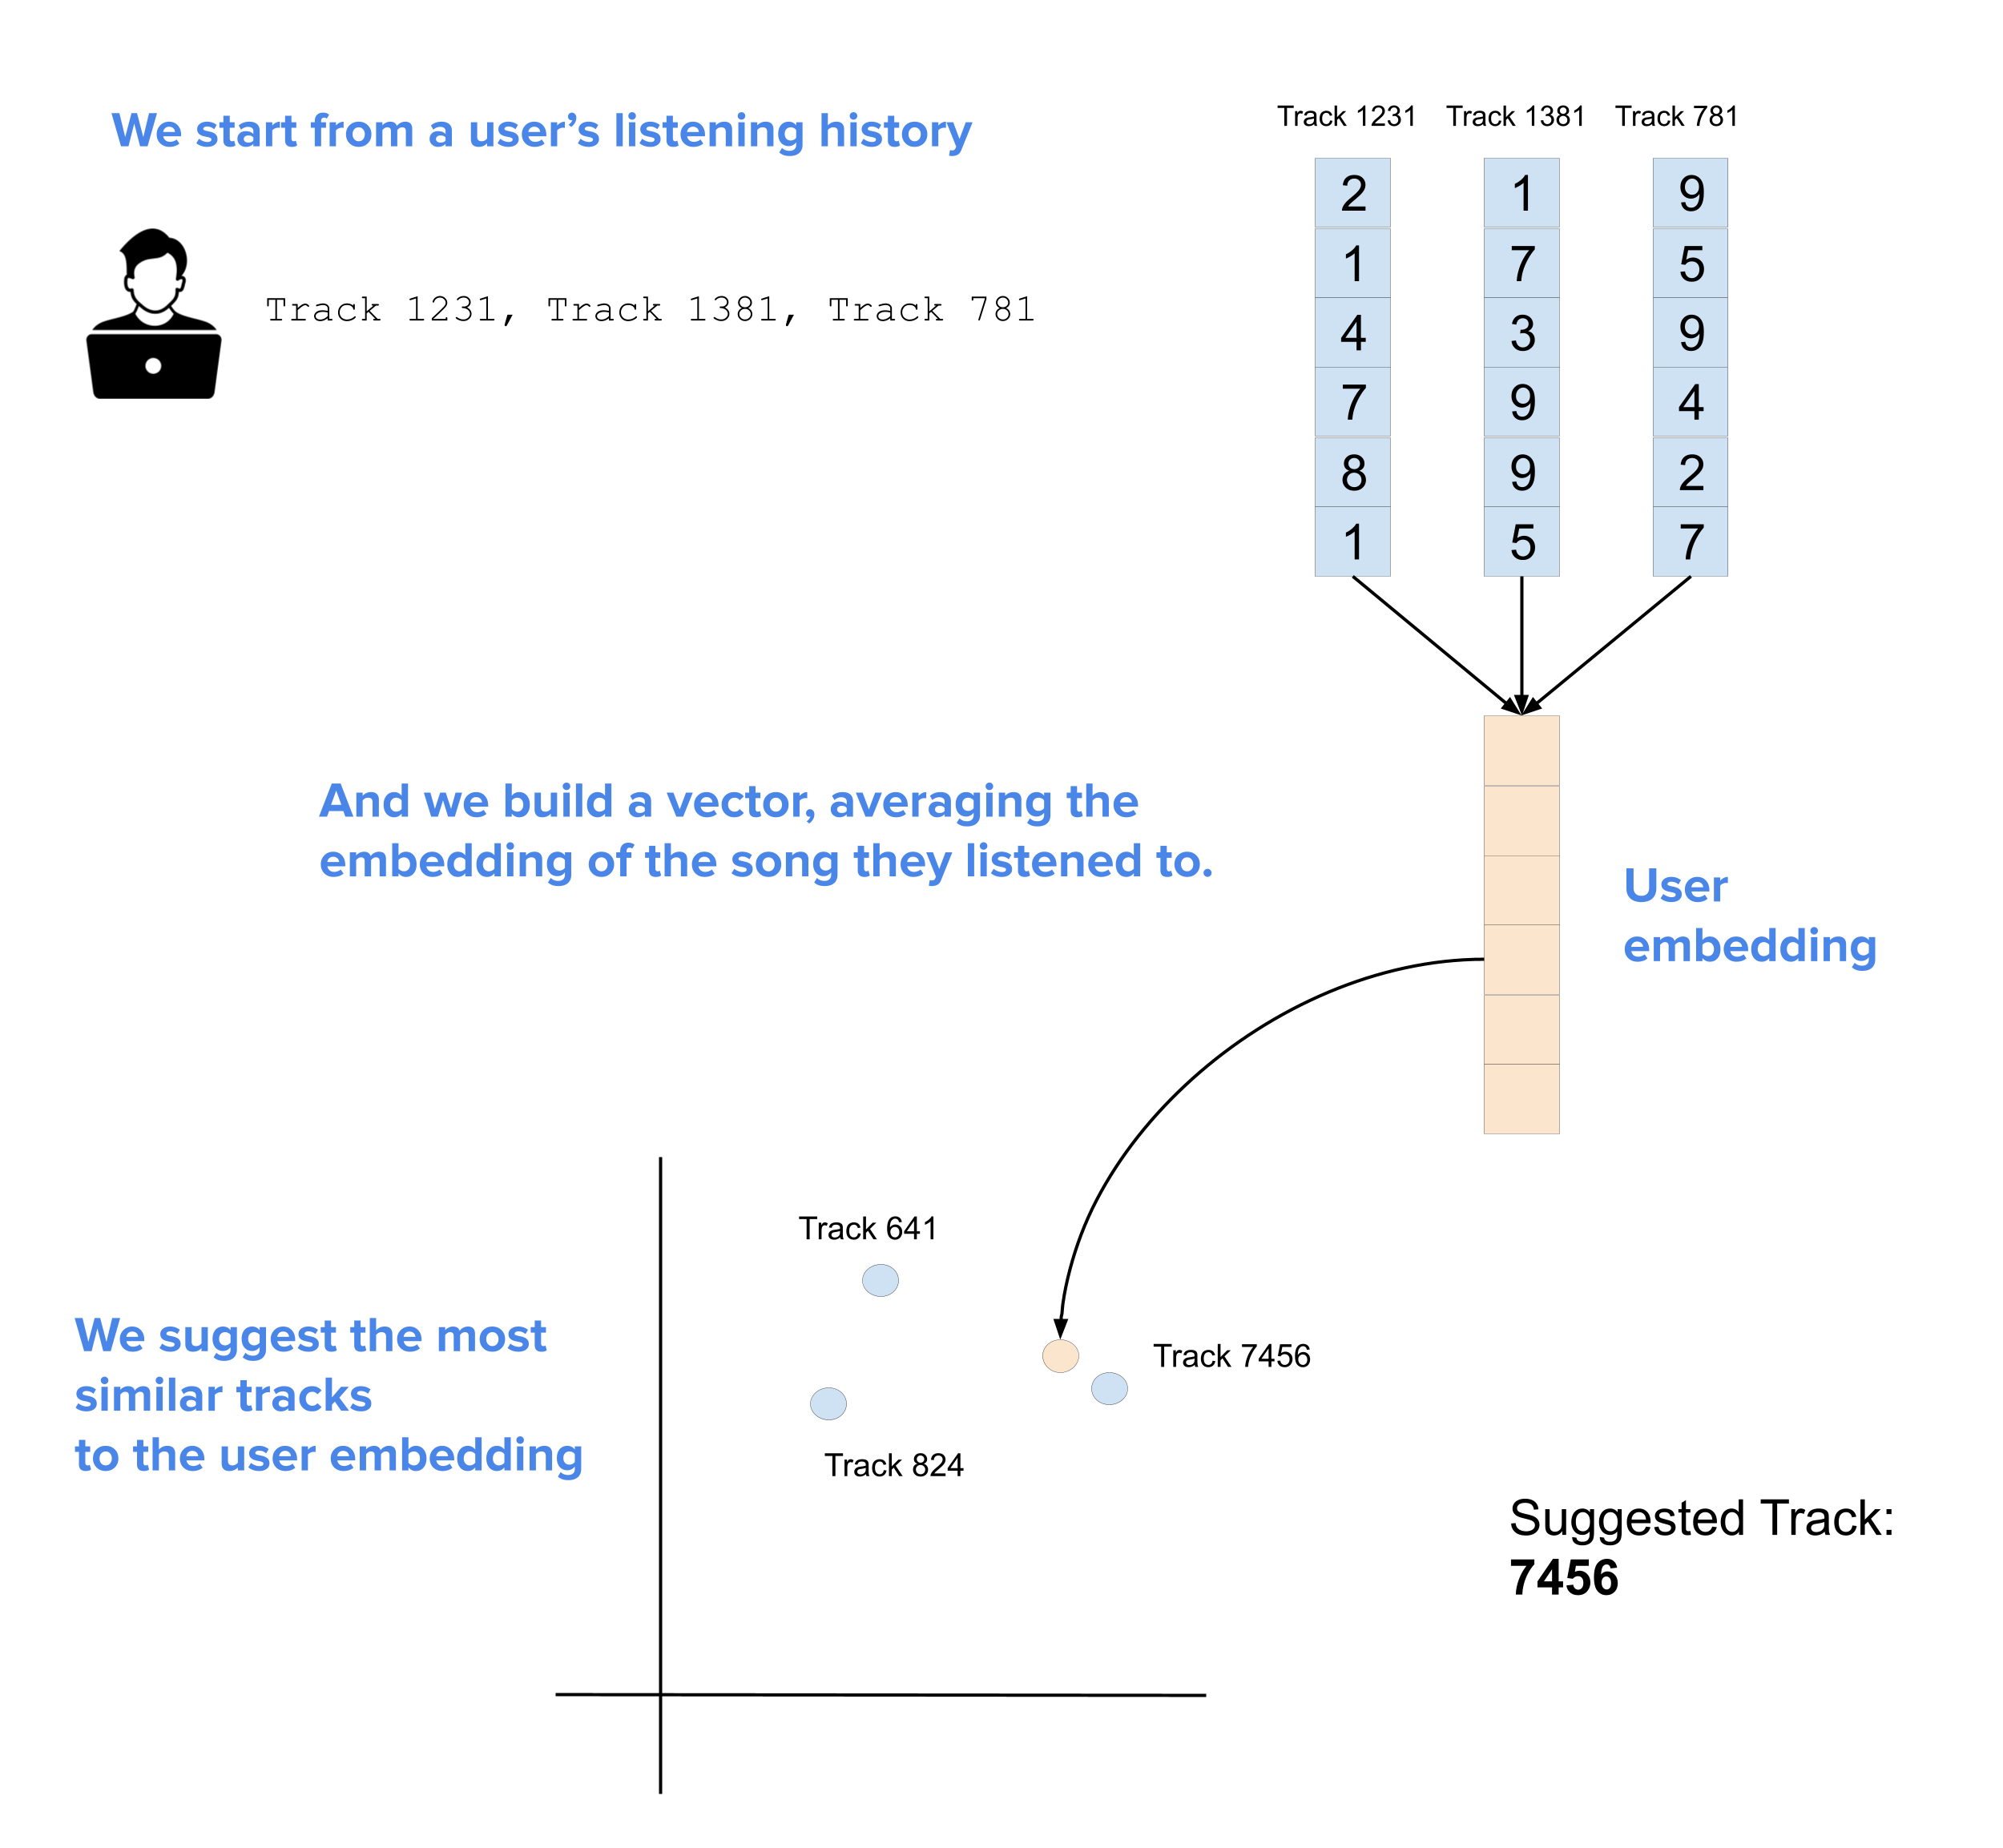

### Code, Please

Here it is:

In [ ]:
df = train_df[['user_id', 'track_id', 'timestamp']].sort_values('timestamp')

In [ ]:
df.groupby('user_id', sort=True)['track_id'].agg(list)

user_id
384         [562698, 198978, 177872, 6415, 1593187, 151506...
2622        [203184, 306037, 5121, 1685127, 63012, 62788, ...
3653        [1037548, 765680, 1082161, 5112, 27750, 391352...
5834        [314692, 19724333, 526902, 12665058, 26917, 17...
10081       [29863925, 789256, 18918, 18105294, 30504585, ...
                                  ...                        
50088630    [182267, 182266, 182265, 182264, 12585504, 161...
50245939    [516853, 14737877, 29459166, 1436528, 1262734,...
50759670    [561219, 561231, 726631, 244988, 45035, 45034,...
50761770    [30146501, 8029892, 103852, 661153, 29448707, ...
50967444    [20607, 20606, 20605, 20604, 608432, 608431, 8...
Name: track_id, Length: 29725, dtype: object

In [ ]:
user_tracks = df.groupby('user_id', sort=True)['track_id'].agg(list)

In [ ]:
seq_tracks = user_tracks.values.tolist()

In [ ]:
word2vec_model = Word2Vec(seq_tracks, min_count=0, vector_size=20, window=40, epochs=5)

In [ ]:
user_tracks_df = pd.DataFrame(user_tracks)

In [ ]:
user_tracks_df['track_id_sampled'] = user_tracks_df['track_id'].apply(lambda x: random.choices(x, k=40))

In [ ]:
user_tracks_df

,track_id,track_id_sampled
user_id,,
384,"[562698, 198978, 177872, 6415, 1593187, 151506...","[68870, 328139, 10330778, 186171, 949365, 7798..."
2622,"[203184, 306037, 5121, 1685127, 63012, 62788, ...","[306037, 318387, 2361114, 105341, 362505, 1022..."
3653,"[1037548, 765680, 1082161, 5112, 27750, 391352...","[160530, 448184, 1928526, 850854, 1128181, 592..."
5834,"[314692, 19724333, 526902, 12665058, 26917, 17...","[287493, 1219718, 112326, 16205882, 250968, 31..."
10081,"[29863925, 789256, 18918, 18105294, 30504585, ...","[680321, 29449502, 29235, 29235, 30539793, 219..."
...,...,...
50088630,"[182267, 182266, 182265, 182264, 12585504, 161...","[162197, 215031, 68163, 29534, 182265, 297427,..."
50245939,"[516853, 14737877, 29459166, 1436528, 1262734,...","[17090, 927141, 715374, 445231, 10416388, 2947..."
50759670,"[561219, 561231, 726631, 244988, 45035, 45034,...","[357312, 561192, 233924, 48471, 196583, 580, 7..."


In [ ]:
mappings = user_tracks_df.T.to_dict()

In [ ]:
list(mappings.keys())[:10]

[384, 2622, 3653, 5834, 10081, 15434, 15541, 1000842, 1007118, 1009181]

We have the list of users and for each user, list of 40 tracks that they may like

Now given the user and the track he just listened what are the others tracks he may like.

In [ ]:
test.iloc[0]

user_id       384
track_id    97653
Name: 323293759, dtype: int32

In [ ]:
user_id=384
k=100

In [ ]:
# for the user get the sampled tracks from the mapping.
u_tracks = mappings[user_id]

In [ ]:
u_tracks.get('track_id')[:10]

[562698, 198978, 177872, 6415, 1593187, 151506, 189483, 1106814, 260694, 1493]

In [ ]:
# mapping b/w keys and vectors
word2vec_model.wv

<gensim.models.keyedvectors.KeyedVectors>

In [ ]:
# lets get vector for a single track
word2vec_model.wv[562698].shape

(20,)

In [ ]:
word2vec_model.wv[u_tracks.get('track_id')[0]]

array([ 0.13259612,  0.27240062, -0.06540779,  0.02737947,  0.30605963,
       -0.74657714, -0.46147314,  0.8053045 , -0.01339404,  0.7868097 ,
       -0.14108227, -1.0705111 , -0.76083267, -0.0073057 , -0.03063416,
       -0.14271344,  0.2370426 , -0.9314594 ,  0.23173666, -0.7301065 ],
      dtype=float32)

In [ ]:
word2vec_model.wv[u_tracks.get('track_id')[1]]

array([ 0.09186017,  2.418743  ,  0.865069  ,  0.13746378,  0.5990799 ,
       -1.4353967 , -2.5353687 , -0.7811534 ,  0.37181237,  0.33890948,
        0.9218124 , -1.136149  , -3.2183924 ,  0.6227271 , -0.6263475 ,
        0.22880977,  0.96315956, -1.5252101 ,  1.6092639 , -0.04416701],
      dtype=float32)

In [ ]:
np.mean([word2vec_model.wv[u_tracks.get('track_id')[0]], word2vec_model.wv[u_tracks.get('track_id')[0]]], axis=0)

array([ 0.13259612,  0.27240062, -0.06540779,  0.02737947,  0.30605963,
       -0.74657714, -0.46147314,  0.8053045 , -0.01339404,  0.7868097 ,
       -0.14108227, -1.0705111 , -0.76083267, -0.0073057 , -0.03063416,
       -0.14271344,  0.2370426 , -0.9314594 ,  0.23173666, -0.7301065 ],
      dtype=float32)

Only when we do column wise averaging, we can get a nuanced user embedding more meaninful capturing the intricate taste profile of the user.

In [ ]:
np.mean([word2vec_model.wv[u_tracks.get('track_id')[0]], word2vec_model.wv[u_tracks.get('track_id')[0]]], axis=1)

array([-0.11510839, -0.11510839], dtype=float32)

When we do row wise, we are just getting average of the numbers from the track.

In [ ]:
from fastcore.all import *
import numpy as np

In [ ]:
a = np.array([[1,2], [3,4]])
test_eq(np.mean(a, axis=0), np.array([2., 3.])) # column wise
test_eq(np.mean(a, axis=1), np.array([1.5, 3.5])) # row wise

In [ ]:
# avg the embedding (column wise) from all tracks to get the user embedding
user_embedding = np.mean([word2vec_model.wv[t] for t in u_tracks.get('track_id')], axis=0)

In [ ]:
max_items_returned = len(u_tracks.get('track_id')) + k; max_items_returned

311

In [ ]:
# Find the top-N most similar keys.: Positive keys contribute positively towards the similarity, negative keys negatively.
preds = word2vec_model.wv.most_similar(positive=[user_embedding], topn=max_items_returned)

In [ ]:
preds[0]

(520161, 0.9930781722068787)

In [ ]:
user_predictions = [each[0] for each in preds];len(user_predictions)

311

In [ ]:
user_predictions = list(filter(lambda x: x not in u_tracks.get('track_id'), user_predictions));len(user_predictions)

310

In [ ]:
class CBOWRecSys(RecModel):

    def __init__(self, top_k: int=100):
        super(CBOWRecSys, self).__init__()
        """
        :param top_k: numbers of recommendation to return for each user. Defaults to 20.
        """
        self.top_k = top_k
        self.mappings = None

    def train(self, train_df: pd.DataFrame, **kwargs):
        
        # let's put tracks in order so we can build those sentences
        df = train_df[['user_id', 'track_id', 'timestamp']].sort_values('timestamp')
        
        # we group by user and create sequences of tracks. 
        # each row in "track_id" will be a sequence of tracks
        p = df.groupby('user_id', sort=False)['track_id'].agg(list)
        
        # we now build "sentences" : sequences of tracks
        sentences = p.values.tolist()

        # train word2vec:
        # large window and small vector size...lots of epochs
        self.mymodel = Word2Vec(sentences, min_count=0, vector_size=20, window=40, epochs=5)
        
        user_tracks = pd.DataFrame(p)
        
        # we sample 40 songs for each user. This will be used at runtime to build
        # a user vector
        user_tracks["track_id_sampled"] = user_tracks["track_id"].apply(lambda x : random.choices(x, k=40)) 

        # this dictionary maps users to the songs:
        # {"user_k" : {"track_id" : [...], "track_id_sampled" : [...]}}
        self.mappings = user_tracks.T.to_dict()

    def predict(self, user_ids: pd.DataFrame) -> pd.DataFrame:

        user_ids = user_ids.copy()
        k = self.top_k

       
        pbar = tqdm(total=len(user_ids), position=0)
        
        predictions = []
        
        # probably not the fastest way to do this
        for user in user_ids["user_id"]:
          
          	# for each user we get their sample tracks
            user_tracks = self.mappings[user]["track_id_sampled"]
            
            # average to get user embedding
            get_user_embedding = np.mean([self.mymodel.wv[t] for t in user_tracks], axis=0)
            
            
            # we need to filter out stuff from the user history. We don't want to suggest to the user 
            # something they have already listened to
            max_number_of_returned_items = len(self.mappings[user]["track_id"]) + self.top_k

            # let's predict the tracks
            user_predictions = [k[0] for k in self.mymodel.wv.most_similar(positive=[get_user_embedding], 
                                                                           topn=max_number_of_returned_items)]
            # let's filter out songs the user has already listened to
            user_predictions = list(filter(lambda x: x not in 
                                           self.mappings[user]["track_id"], user_predictions))[0:self.top_k]
            
            # append to the return list
            predictions.append(user_predictions)

            pbar.update(1)
        pbar.close()
        
        # lil trick to reconstruct a dataframe that has user ids as index and the predictions as columns
        # This is a very important part! consistency in how you return the results is fundamental for the 
        # evaluation
     
        users = user_ids["user_id"].values.reshape(-1, 1)
        predictions = np.concatenate([users, np.array(predictions)], axis=1)
        return pd.DataFrame(predictions, columns=['user_id', *[str(i) for i in range(k)]]).set_index('user_id')

In [ ]:
# instantiate this
cbow_recsys = CBOWRecSys()

next step should take 5-6 minutes to train

In [ ]:
%%time
cbow_recsys.train(train_df)

CPU times: user 5min 58s, sys: 2.66 s, total: 6min
Wall time: 2min 19s


In [ ]:
predicted = cbow_recsys.predict(test_df.sample(10)) # let's test only on a couple of elements

  0%|                                                                                          | 0/10 [00:00<?, ?it/s]

KeyError: 46818662

the predictions is a pandas dataframe, with user ids and the topk items predicted for a user

In [ ]:
predicted

### Intermezzo: Explore and Visualize Track Embeddings


A lot of the code here comes from this [very nice blog post](https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d).

In [ ]:
def get_embedding_from_id(internal_id):
    return cbow_recsys.mymodel.wv[internal_id]

def get_most_similar_with_titles(internal_id):
    """
    returns most similar songs to a track id. returned songs will appear in the format: title - author
    """
    return [(get_song_name(k[0]), get_artist_from_song_id(k[0])) for k in cbow_recsys.mymodel.wv.most_similar(internal_id)]

Let's take an Enter Shikari song and let's print the neighborhood

In [ ]:
get_song_name(18581)

In [ ]:
get_most_similar_with_titles(18581)

Well these similar tracks makes sense! 

Let's look at another song...maybe from All Time Low now?

In [ ]:
get_artist_from_song_id(14634537)

In [ ]:
get_song_name(14634537)

In [ ]:
get_most_similar_with_titles(14634537)

Very cool! The embedding seems good! (we could probably improve it with some more careful training, but it should be good for now).

### Plotting


We now get some songs and try to plot them using T-SNE.

In [ ]:
import random

# getting some songs from the vocab (you can get this from the tracks list, e.g., "2" is Hanger 18 from Megadeth)
sample_from_vocab = [2, 50630, 16110, 759, 18581]


sample_from_vocab_named = [f"{get_song_name(k)} - {get_artist_from_song_id(k)}" for k in sample_from_vocab]

embedding_clusters = []
word_clusters = []
for word in sample_from_vocab:
    embeddings = []
    words = []
    
    for similar_word, _ in cbow_recsys.mymodel.wv.most_similar(word, topn=5):
        words.append(f"{get_song_name(similar_word)} - {get_artist_from_song_id(similar_word)}")
        embeddings.append(cbow_recsys.mymodel.wv[similar_word])

    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [ ]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, n_iter=8000, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [ ]:
def tsne_plot_similar_tracks(title, labels, embedding_clusters, word_clusters, a):
    """
    Function to plot TSNE embeddings
    """
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
  
    plt.show()

In [ ]:
tsne_plot_similar_tracks('Clusters Of Tracks', sample_from_vocab_named, embeddings_en_2d, word_clusters, 0.7)

## Evaluation

We need to create our evaluation runner. The class accepts a couple of paramters but we ignore them for now, they are mainly useful for paper submission.

In [ ]:
runner = EvalRSRunner(dataset)

This is going to take a bit...

In [ ]:
cbow_recsys = CBOWRecSys()
runner.evaluate(cbow_recsys, upload=False)

# What Now?

Well we haven't really submitted anything to the leaderboard yet. To do this, you first need to register to the challenge.

You can follow [the instructions here](https://github.com/RecList/evalRS-CIKM-2022#how-to-join-the-race)! Good Luck!

In [ ]:
# this is the runner you need to prepare to submit
runner = EvalRSRunner(
    dataset=dataset,
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY,
    participant_id=PARTICIPANT_ID,
    bucket_name=BUCKET_NAME,
    email=EMAIL
    )